In [1]:
# Import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import calendar
import re
import json

In [2]:
# Seaborn settings
#sns.set_palette("deep", desat = 0.6)
sns.set_context(rc={"figure.figsize": (10,6)})
sns.set_style("white")

In [3]:
# Import data
# Overall film data
films = pd.read_csv('data/films_cleaned.csv')
films = films.sort_values(by=['AdjustedDomesticGross', 'Budget']).drop_duplicates(['movieID'])
# Detailed weekend data
wend = pd.read_csv('data/weekend-cleaned.csv')
# Transformed weekend data
trns = pd.read_csv('data/weekend-tranformed.csv')

# Merge overall film data and transformed weekend data
complete = films.merge(trns,how='left')

In [4]:
# Function for grouping genres into less specific categories
def top_genre(s):
    if s in ['Action','Action / Adventure','Action / Crime','Action Comedy','Action Drama','Action Fantasy',
     'Action Horror','Action Thriller','Adventure','Adventure Comedy']:
        return "Action/Adventure"
    elif s == 'Animation':
        return "Animation"
    elif s in ['Comedy', 'Comedy / Drama', 'Comedy Thriller']:
        return "Comedy"
    elif s in ['Crime Drama', 'Crime Thriller', 'Drama', 'Drama / Thriller','Thriller']:
        return "Drama/Thriller"
    elif s in ['Horror', 'Horror Comedy', 'Horror Thriller']:
        return "Horror"
    elif s in ['Romance', 'Romantic Adventure', 'Romantic Comedy', 'Romantic Thriller']:
        return "Romance"
    elif s in ['Sci-Fi', 'Sci-Fi Action', 'Sci-Fi Adventure', 'Sci-Fi Comedy', 'Sci-Fi Fantasy', 'Sci-Fi Horror', 'Sci-Fi Thriller']:
        return "SciFi"
    else:
        return "Other"

In [5]:
# Create new column with top-level genre
complete['Major_Genre'] = complete['Genre'].apply(top_genre)

# Create new column with $ amount drop between week 1 and week 2
complete['w1_$_drop'] = complete['w_1_gross'] - complete['w_2_gross']

In [6]:
# Function for getting numeric values from budget string
def extract_budget(s):
    if 'million' in str(s):
        return int(re.search('(\d+)', str(s)).group(0)+'000000')
    elif re.search('(\d+,?\d+)', str(s)):
        return int(s.replace(',','').replace('$',''))
        #return int(re.search('(\d+,?\d+)', str(s)).group(0).replace(',',''))
    else:
        return np.nan

In [7]:
# Extract budget value from text
complete['budget_val'] = complete['Budget'].apply(extract_budget)

In [8]:
# Need to deal with some missing Release Years
d = json.load(open("data/out.txt"))
from datetime import datetime
def convert_date(inp):
    string = str(inp)
    if string == 'nan' or string == "N/A":
        return np.nan
    elif re.match(r'\d{4}-\d{2}-\d{2}',string):
        return string
    elif re.match(r'\D+\d+, \d+',string):
        return datetime.strftime(datetime.strptime(string, "%B %d, %Y"), "%Y-%m-%d")
    elif re.match(r'\D+\d+',string):
        return datetime.strftime(datetime.strptime(string, "%B %Y"), "%Y-%m-%d")
    else:
        return np.nan

for k, v in d.items():
    complete['ReleaseDate'][complete.movieID == k] = convert_date(v)

/Users/simonbedford/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
complete['Release_Year'] = pd.DatetimeIndex(complete['ReleaseDate']).year
complete['Release_Month'] = pd.DatetimeIndex(complete['ReleaseDate']).month

In [10]:
# Need to adjust budgets for inflation
rate = {}
import csv
with open("data/inflation.csv","r") as f:
    d = csv.reader(f)
    next(f, None)
    for row in d:
        rate[float(row[0])] = float(row[1])

In [11]:
def adjust_budget(row):
    if np.isnan(row[0]) or np.isnan(row[1]):
        return np.nan
    else:
        if row[1] in rate.keys():
            return row[0]*rate[row[1]]
        else:
            return np.nan

In [12]:
complete['adjusted_budget'] = complete[['budget_val','Release_Year']].apply(lambda row: adjust_budget(row),axis=1)

In [13]:
# Absolute profit
complete['abs_profit'] = complete['AdjustedDomesticGross'] - complete['adjusted_budget']
# Relative profit
complete['rel_profit'] = complete['AdjustedDomesticGross'] / complete['adjusted_budget']
# Week 1 success (weekend 1 gross / budget)
complete['w_1_success'] = complete['w_1_gross']/complete['adjusted_budget']
# Week 1 and 2 success (weekends 1 and 2 gross / budget)
complete['w_1_and_2_success'] = (complete['w_1_gross']+complete['w_2_gross'])/complete['adjusted_budget'] * 100

In [14]:
#complete.to_csv('all_cleaned_data.csv', index=False)

##### Q0: What does the dataset look like?

In [15]:
print("Number of films: %s" % len(complete))

Number of films: 16065


In [16]:
complete.dtypes

movieLink                 object
movieID                   object
name                      object
AdjustedDomesticGross    float64
ReleaseDate               object
Distributor               object
Genre                     object
Budget                    object
_merge                    object
Release_Year             float64
Release_Month            float64
Year                     float64
w2_$_change              float64
w2_rank_change           float64
w3_$_change              float64
w3_rank_change           float64
w_1_date                  object
w_1_gross                float64
w_1_rank                 float64
w_2_date                  object
w_2_gross                float64
w_2_rank                 float64
w_3_date                  object
w_3_gross                float64
w_3_rank                 float64
Major_Genre               object
w1_$_drop                float64
budget_val               float64
adjusted_budget          float64
abs_profit               float64
rel_profit

In [17]:
complete.describe()

,AdjustedDomesticGross,Release_Year,Release_Month,Year,w2_$_change,w2_rank_change,w3_$_change,w3_rank_change,w_1_gross,w_1_rank,...,w_2_rank,w_3_gross,w_3_rank,w1_$_drop,budget_val,adjusted_budget,abs_profit,rel_profit,w_1_success,w_1_and_2_success
count,1.406400e+04,14264.000000,14264.000000,12577.000000,9200.000000,8880.000000,7649.000000,7557.000000,1.257100e+04,10770.000000,...,9179.000000,8.328000e+03,8038.000000,9.571000e+03,2.972000e+03,2.912000e+03,2.887000e+03,2887.000000,2838.000000,2643.000000
mean,3.037428e+07,2002.806646,6.715227,2003.037688,-9.673522,-3.397748,-12.753353,-3.790790,6.698044e+06,37.907521,...,36.761957,3.567216e+06,37.987186,3.370880e+06,4.229327e+07,5.285389e+07,2.624382e+07,7.128299,0.617323,112.150528
std,7.423284e+07,10.016689,3.353104,9.288715,100.098134,10.435668,92.408299,10.429337,1.551503e+07,35.223613,...,35.309917,6.302855e+06,35.705742,9.089873e+06,4.400532e+07,5.107610e+07,8.968120e+07,154.118439,3.040790,772.232548
min,1.000000e+02,1921.000000,1.000000,1972.000000,-99.600000,-88.000000,-99.400000,-71.000000,1.000000e+02,1.000000,...,1.000000,1.000000e+02,1.000000,-9.473570e+07,2.200000e+02,2.750000e+02,-1.799487e+08,0.000080,0.000080,0.084127
25%,8.492500e+04,1996.000000,4.000000,1997.000000,-54.800000,-6.000000,-54.800000,-6.000000,1.450000e+04,4.000000,...,6.000000,1.667500e+04,8.000000,6.000000e+02,1.200000e+07,1.635000e+07,-1.398970e+07,0.507087,0.104736,21.951552
50%,1.630450e+06,2005.000000,7.000000,2005.000000,-38.200000,-2.000000,-37.800000,-3.000000,1.389000e+05,28.000000,...,21.000000,3.917500e+05,22.000000,5.110000e+04,2.800000e+07,3.612000e+07,3.087200e+06,1.120493,0.288393,49.939312
75%,2.793342e+07,2011.000000,10.000000,2011.000000,-6.675000,0.000000,-8.000000,0.000000,7.337850e+06,67.000000,...,64.500000,4.718625e+06,65.000000,3.750900e+06,6.000000e+07,7.506750e+07,4.066515e+07,2.219366,0.558256,91.940228
max,1.686000e+09,2016.000000,12.000000,2016.000000,998.000000,60.000000,992.000000,71.000000,2.402712e+08,145.000000,...,156.000000,6.899060e+07,152.000000,1.292818e+08,3.000000e+08,3.420000e+08,1.160238e+09,7244.933333,100.225000,32945.454545


##### Q1: What have been the most successful films

In [18]:
cp = sns.color_palette("GnBu_r", 10)

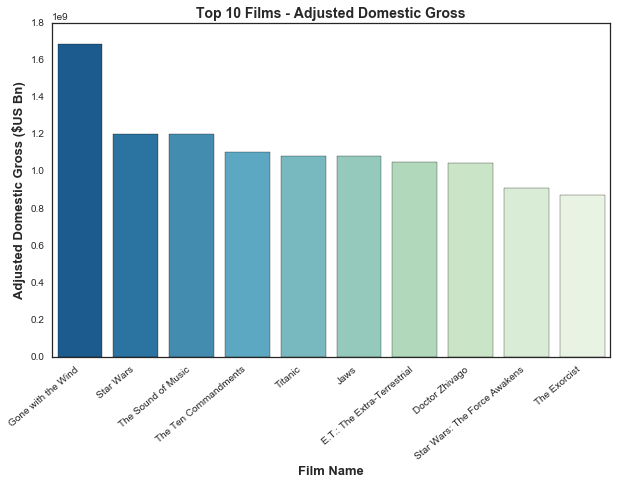

In [19]:
# Most successful films by Total Gross
top10 = complete.sort_values(by='AdjustedDomesticGross', ascending=False).head(10)[['name','AdjustedDomesticGross']]
ax = sns.barplot(top10['name'], top10['AdjustedDomesticGross'], palette=cp)
plt.xlabel('Film Name', fontsize=13, weight='bold')
plt.ylabel('Adjusted Domestic Gross ($US Bn)', fontsize=13, weight='bold')
ax.set_xticklabels(top10['name'], rotation=40, ha='right')
plt.title('Top 10 Films - Adjusted Domestic Gross', fontsize=14, weight='bold')
plt.show()

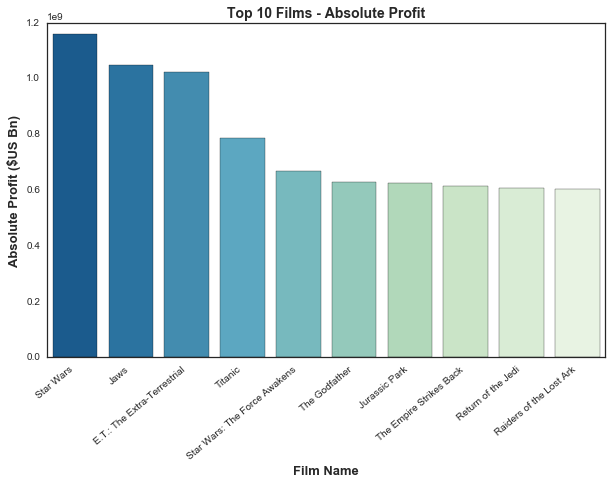

In [20]:
# Most successful films by Absolute Profit = Adjusted Domestic Gross - Budget
top10 = complete.sort_values(by='abs_profit', ascending=False).head(10)[['name','abs_profit']]
ax = sns.barplot(top10['name'], top10['abs_profit'], palette=cp)
plt.xlabel('Film Name', fontsize=13, weight='bold')
plt.ylabel('Absolute Profit ($US Bn)', fontsize=13, weight='bold')
ax.set_xticklabels(top10['name'], rotation=40, ha='right')
plt.title('Top 10 Films - Absolute Profit', fontsize=14, weight='bold')
plt.show()

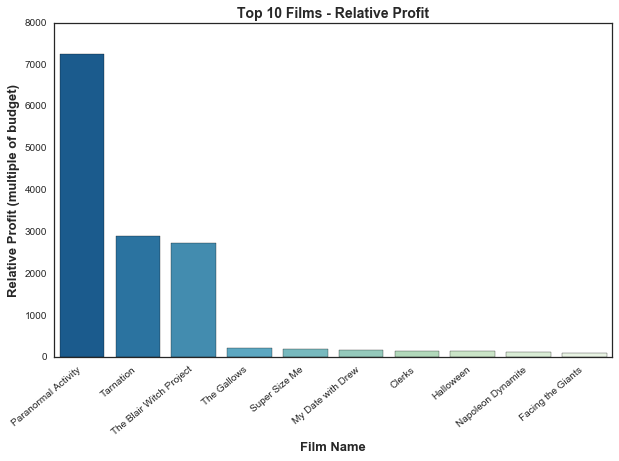

In [21]:
# Most successful films by Relative Profit (all films)
top10 = complete.sort_values(by='rel_profit', ascending=False).head(10)[['name','rel_profit']]
ax = sns.barplot(top10['name'], top10['rel_profit'], palette=cp)
plt.xlabel('Film Name', fontsize=13, weight='bold')
plt.ylabel('Relative Profit (multiple of budget)', fontsize=13, weight='bold')
ax.set_xticklabels(top10['name'], rotation=40, ha='right')
plt.title('Top 10 Films - Relative Profit', fontsize=14, weight='bold')
plt.show()

In [22]:
# Budget for Top 10 films by Relative Profit
complete.sort_values(by='rel_profit', ascending=False).head(10)[['name','Budget']]

,name,Budget
13120,Paranormal Activity,"$15,000"
6234,Tarnation,$220
13711,The Blair Witch Project,"$60,000"
10231,The Gallows,"$100,000"
9575,Super Size Me,"$65,000"
4808,My Date with Drew,"$1,100"
8478,Clerks,"$27,000"
13466,Halloween,"$325,000"
12014,Napoleon Dynamite,"$400,000"
9328,Facing the Giants,"$100,000"


In [23]:
# As a sub-category, look at films whose budget is in the top two quartiles
median_budget = complete[complete['adjusted_budget'] > complete['adjusted_budget'].median()]

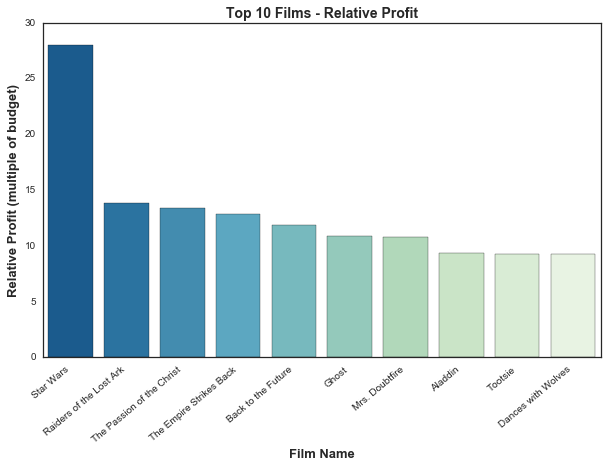

In [24]:
# Most successful films by Relative Profit (films where budget > median budget)
top10 = median_budget.sort_values(by='rel_profit', ascending=False).head(10)[['name','rel_profit']]
ax = sns.barplot(top10['name'], top10['rel_profit'], palette=cp)
plt.xlabel('Film Name', fontsize=13, weight='bold')
plt.ylabel('Relative Profit (multiple of budget)', fontsize=13, weight='bold')
ax.set_xticklabels(top10['name'], rotation=40, ha='right')
plt.title('Top 10 Films - Relative Profit', fontsize=14, weight='bold')
plt.show()

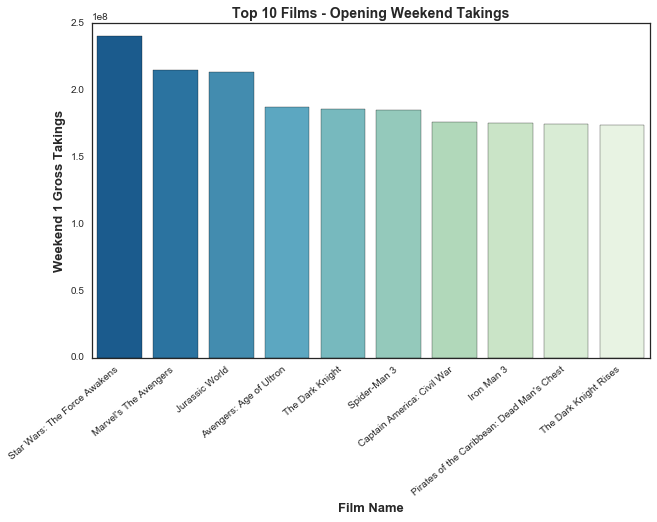

In [25]:
# Most successful films by Week 1 Gross
top10 = median_budget.sort_values(by='w_1_gross', ascending=False).head(10)[['name','w_1_gross']]
ax = sns.barplot(top10['name'], top10['w_1_gross'], palette=cp)
plt.xlabel('Film Name', fontsize=13, weight='bold')
plt.ylabel('Weekend 1 Gross Takings', fontsize=13, weight='bold')
ax.set_xticklabels(top10['name'], rotation=40, ha='right')
plt.title('Top 10 Films - Opening Weekend Takings', fontsize=14, weight='bold')
plt.show()

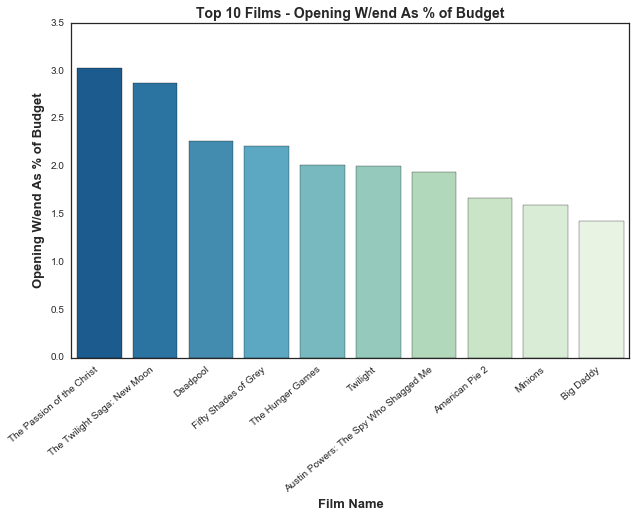

In [26]:
# Most successful films by Week 1 Gross / Budget (budget > median)
top10 = median_budget.sort_values(by='w_1_success', ascending=False).head(10)[['name','w_1_success']]
ax = sns.barplot(top10['name'], top10['w_1_success'], palette=cp)
plt.xlabel('Film Name', fontsize=13, weight='bold')
plt.ylabel('Opening W/end As % of Budget', fontsize=13, weight='bold')
ax.set_xticklabels(top10['name'], rotation=40, ha='right')
plt.title('Top 10 Films - Opening W/end As % of Budget', fontsize=14, weight='bold')
plt.show()

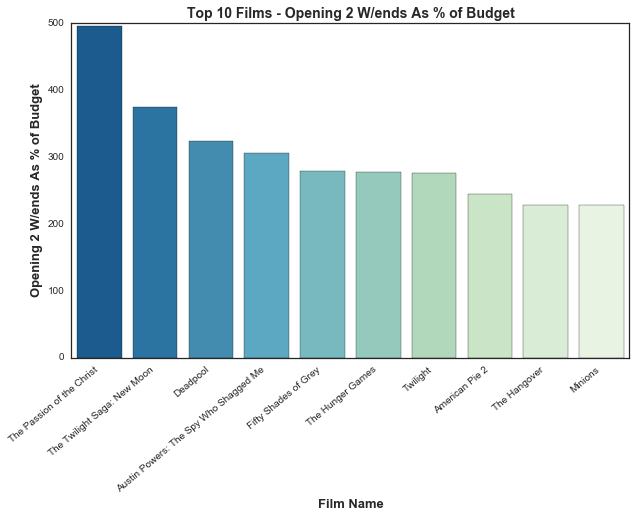

In [27]:
# Most successful films by Week 1 & 2 Gross / Budget
top10 = median_budget.sort_values(by='w_1_and_2_success', ascending=False).head(10)[['name','w_1_and_2_success']]
ax = sns.barplot(top10['name'], top10['w_1_and_2_success'], palette=cp)
plt.xlabel('Film Name', fontsize=13, weight='bold')
plt.ylabel('Opening 2 W/ends As % of Budget', fontsize=13, weight='bold')
ax.set_xticklabels(top10['name'], rotation=40, ha='right')
plt.title('Top 10 Films - Opening 2 W/ends As % of Budget', fontsize=14, weight='bold')
plt.show()

##### Q2. What are the most successful genres?

In [28]:
cp = sns.color_palette("BuGn_r", 10)

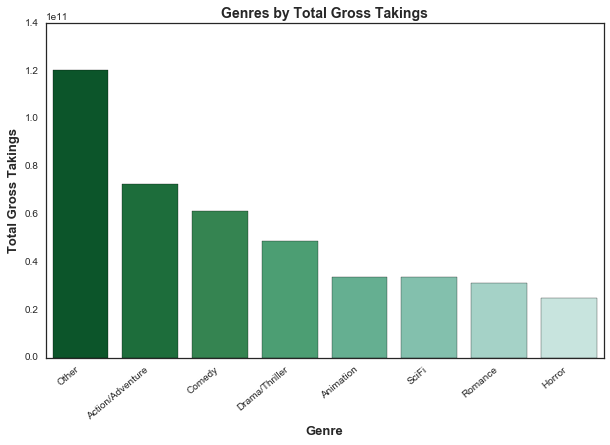

In [29]:
# Most successful genres by Total Adjusted Gross Domestic Takings
top = complete.groupby('Major_Genre')['AdjustedDomesticGross'].sum().sort_values(ascending=False)
ax = sns.barplot(top.index, top.values, palette=cp)
plt.xlabel('Genre', fontsize=13, weight='bold')
plt.ylabel('Total Gross Takings', fontsize=13, weight='bold')
ax.set_xticklabels(top.index, rotation=40, ha='right')
plt.title('Genres by Total Gross Takings', fontsize=14, weight='bold')
plt.show()

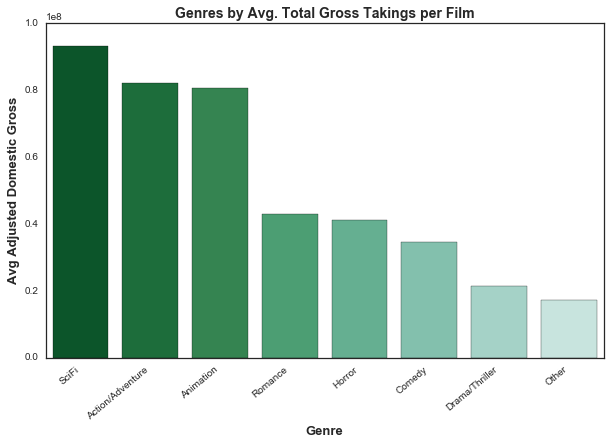

In [30]:
# Most successful genres by average Total Gross
top = complete.groupby('Major_Genre')['AdjustedDomesticGross'].mean().sort_values(ascending=False)
ax = sns.barplot(top.index, top.values, palette=cp)
plt.xlabel('Genre', fontsize=13, weight='bold')
plt.ylabel('Avg Adjusted Domestic Gross', fontsize=13, weight='bold')
ax.set_xticklabels(top.index, rotation=40, ha='right')
plt.title('Genres by Avg. Total Gross Takings per Film', fontsize=14, weight='bold')
plt.show()

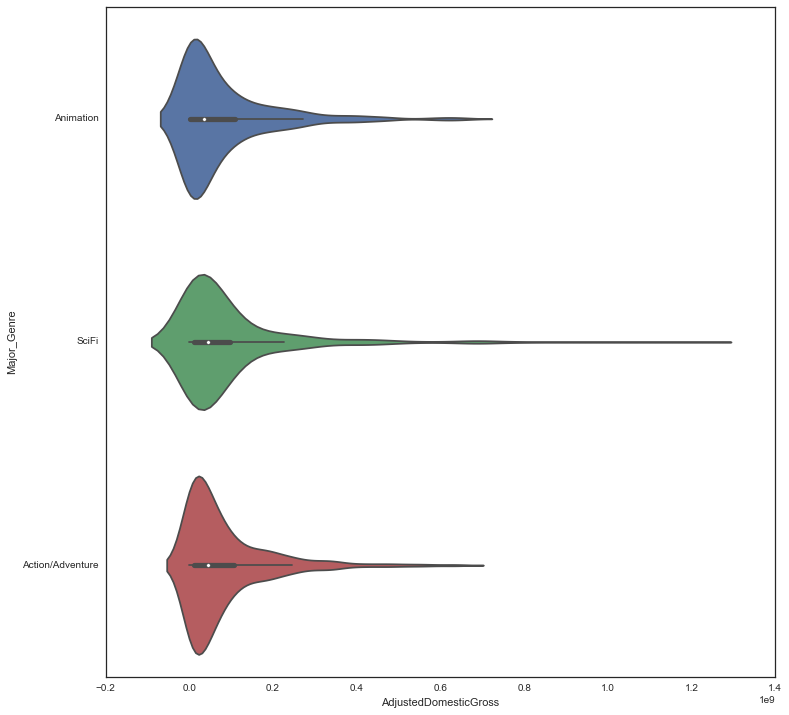

In [31]:
sns.set_context(rc={"figure.figsize": (12,12)})
top_genres = complete[complete['Major_Genre'].str.contains('SciFi|Action/Adventure|Animation')]
sns.violinplot(top_genres['AdjustedDomesticGross'].dropna(), top_genres['Major_Genre']);

In [32]:
sns.set_context(rc={"figure.figsize": (8,4)})

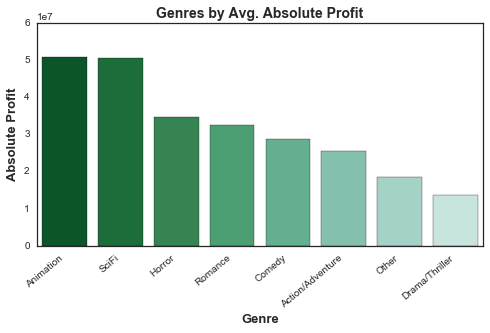

In [33]:
# Most successful genres by average Absolute Profit
top = complete.groupby('Major_Genre')['abs_profit'].mean().sort_values(ascending=False)
ax = sns.barplot(top.index, top.values, palette=cp)
plt.xlabel('Genre', fontsize=13, weight='bold')
plt.ylabel('Absolute Profit', fontsize=13, weight='bold')
ax.set_xticklabels(top.index, rotation=40, ha='right')
plt.title('Genres by Avg. Absolute Profit', fontsize=14, weight='bold')
plt.show()

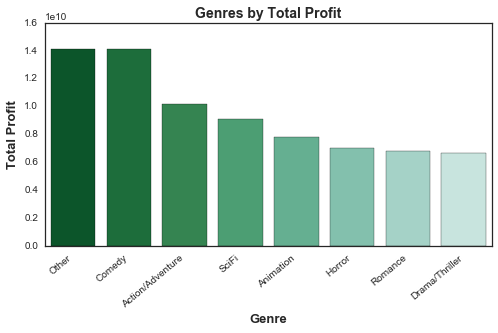

In [34]:
# Total Profit Available per Genre
top = complete.groupby('Major_Genre')['abs_profit'].sum().sort_values(ascending=False)
ax = sns.barplot(top.index, top.values, palette=cp)
plt.xlabel('Genre', fontsize=13, weight='bold')
plt.ylabel('Total Profit', fontsize=13, weight='bold')
ax.set_xticklabels(top.index, rotation=40, ha='right')
plt.title('Genres by Total Profit', fontsize=14, weight='bold')
plt.show()

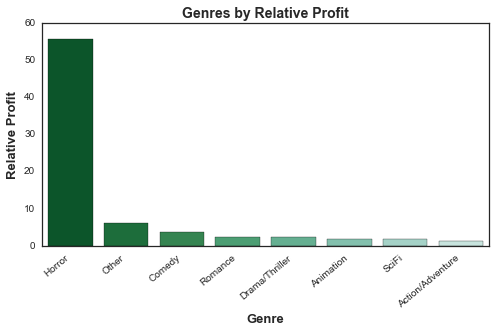

In [35]:
# Most successful genres by average Relative Profit
top = complete.groupby('Major_Genre')['rel_profit'].mean().sort_values(ascending=False)
ax = sns.barplot(top.index, top.values, palette=cp)
plt.xlabel('Genre', fontsize=13, weight='bold')
plt.ylabel('Relative Profit', fontsize=13, weight='bold')
ax.set_xticklabels(top.index, rotation=40, ha='right')
plt.title('Genres by Relative Profit', fontsize=14, weight='bold')
plt.show()

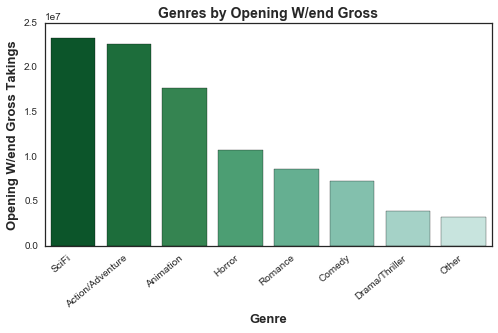

In [36]:
# Most successful genres by Week 1 Gross Takings
top = complete.groupby('Major_Genre')['w_1_gross'].mean().sort_values(ascending=False)
ax = sns.barplot(top.index, top.values, palette=cp)
plt.xlabel('Genre', fontsize=13, weight='bold')
plt.ylabel('Opening W/end Gross Takings', fontsize=13, weight='bold')
ax.set_xticklabels(top.index, rotation=40, ha='right')
plt.title('Genres by Opening W/end Gross', fontsize=14, weight='bold')
plt.show()

In [37]:
# Lets look at horror in more detail a second
# Distribution of budget vs. Gross Takings

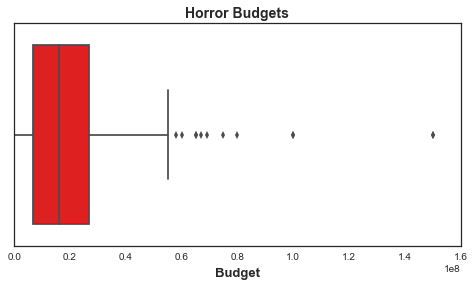

In [38]:
ax = sns.boxplot(complete[complete['Major_Genre'] == 'Horror']['budget_val'].dropna(), color="Red")
plt.xlabel('Budget', fontsize=13, weight='bold')
plt.title('Horror Budgets', fontsize=14, weight='bold')
plt.show()

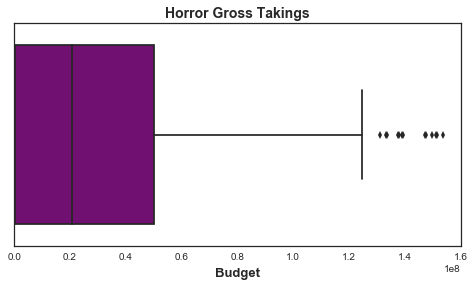

In [39]:
sns.boxplot(complete[complete['Major_Genre'] == 'Horror']['AdjustedDomesticGross'].dropna(), color="Purple")
plt.xlabel('Budget', fontsize=13, weight='bold')
plt.title('Horror Gross Takings', fontsize=14, weight='bold')
plt.xlim(0,1.6e8)
plt.show()

##### Q3. What has happened to film budgets over time?

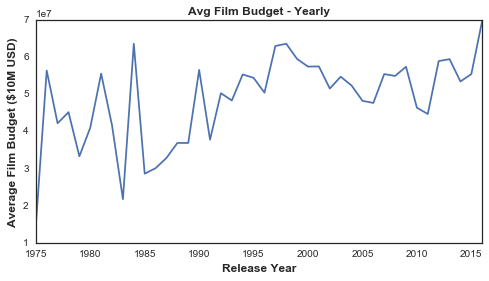

In [40]:
ax = complete[complete['Release_Year']>=1975].groupby('Release_Year')['adjusted_budget'].mean().plot()
plt.xlabel('Release Year', fontsize=12, weight='bold')
plt.ylabel('Average Film Budget ($10M USD)', fontsize=12, weight='bold')
plt.title('Avg Film Budget - Yearly', fontsize=12, weight='bold')
plt.show()

In [41]:
cp = sns.color_palette("deep", 10)
plt.style.use('ggplot')

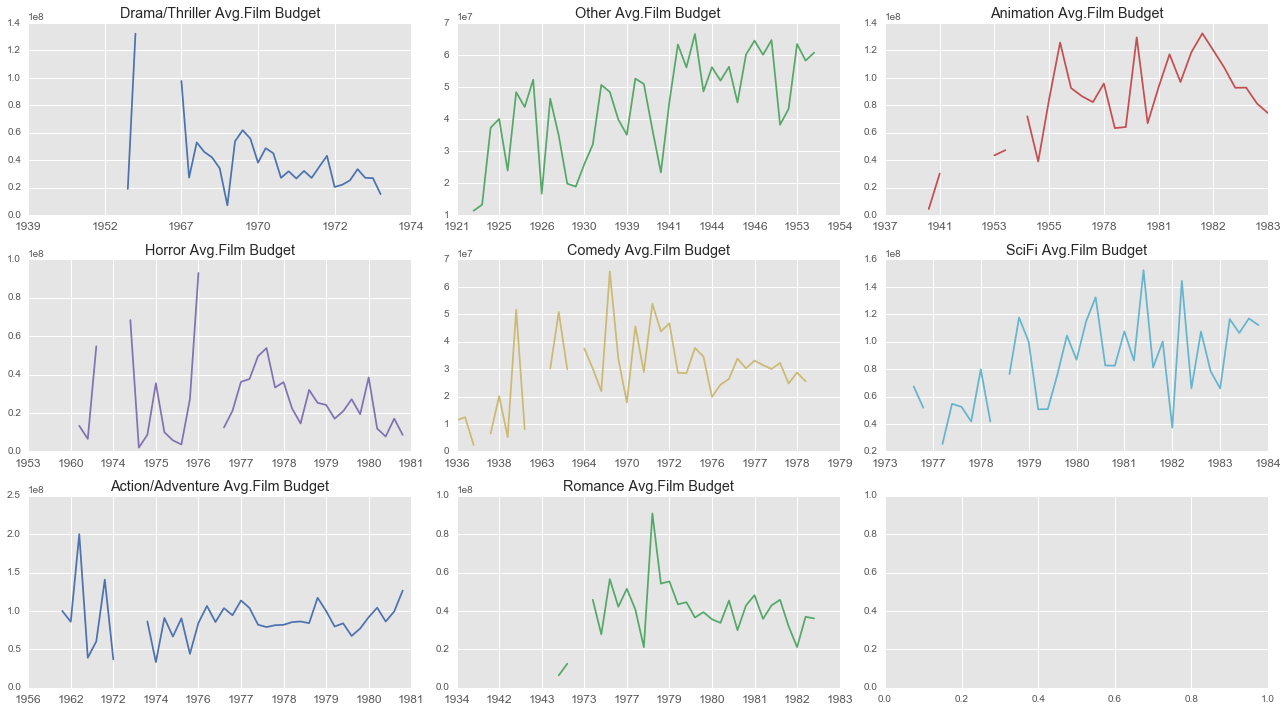

In [42]:
fig,axes = plt.subplots(3,3,figsize=(18,10))
genres = complete['Major_Genre'].unique()

for g,ax,c in zip(genres, axes.reshape(-1),cp):
    data = complete[complete['Major_Genre'] == g].groupby('Release_Year')['adjusted_budget'].mean()
    ax.plot(data.values, color=c)
    ax.set_title(g+" Avg.Film Budget")
    ax.set_xticklabels([int(d) for d in data.index], fontsize=12)
fig.tight_layout()

##### Q4. What has happened to opening weekend takings over time?

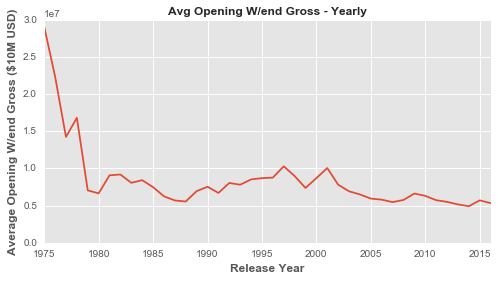

In [43]:
ax = complete[complete['Release_Year']>=1975].groupby('Release_Year')['w_1_gross'].mean().plot()
plt.xlabel('Release Year', fontsize=12, weight='bold')
plt.ylabel('Average Opening W/end Gross ($10M USD)', fontsize=12, weight='bold')
plt.title('Avg Opening W/end Gross - Yearly', fontsize=12, weight='bold')
plt.show()

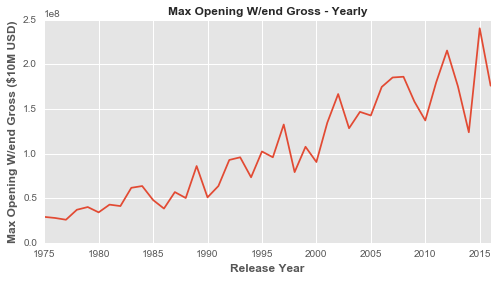

In [44]:
ax = complete[complete['Release_Year']>=1975].groupby('Release_Year')['w_1_gross'].max().plot()
plt.xlabel('Release Year', fontsize=12, weight='bold')
plt.ylabel('Max Opening W/end Gross ($10M USD)', fontsize=12, weight='bold')
plt.title('Max Opening W/end Gross - Yearly', fontsize=12, weight='bold')
plt.show()

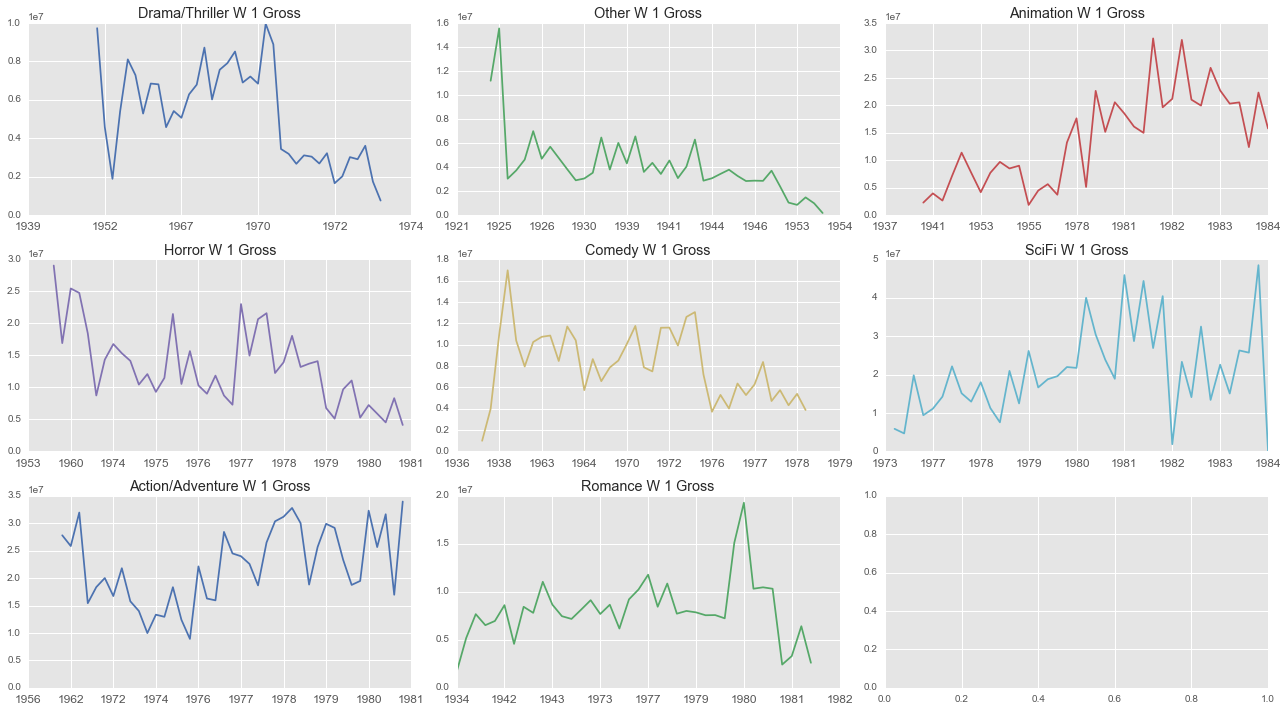

In [45]:
fig,axes = plt.subplots(3,3,figsize=(18,10))
genres = complete['Major_Genre'].unique()

for g,ax,c in zip(genres, axes.reshape(-1),cp):
    data = complete[complete['Major_Genre'] == g].groupby('Release_Year')['w_1_gross'].mean()
    ax.plot(data.values, color=c)
    ax.set_title(g+" W 1 Gross")
    ax.set_xticklabels([int(d) for d in data.index], fontsize=12)
fig.tight_layout()

##### Q6. What is the best month for releasing films?

In [46]:
sns.set_style("white")

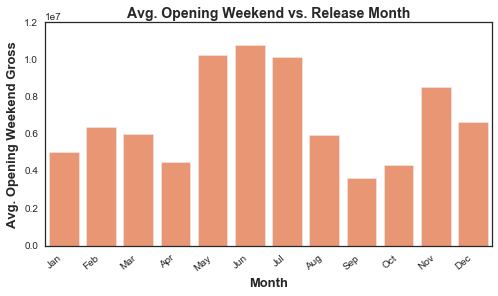

In [47]:
#Average opening weekend gross takings vs. Release Month
months = complete.groupby('Release_Month')['w_1_gross'].mean().sort_index()
ax = sns.barplot(months.index, months.values, color="#fc8d62")
plt.xlabel('Month', fontsize=13, weight='bold')
plt.ylabel('Avg. Opening Weekend Gross', fontsize=13, weight='bold')
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names, rotation=40, ha='right')
plt.title('Avg. Opening Weekend vs. Release Month', fontsize=14, weight='bold')
plt.show()

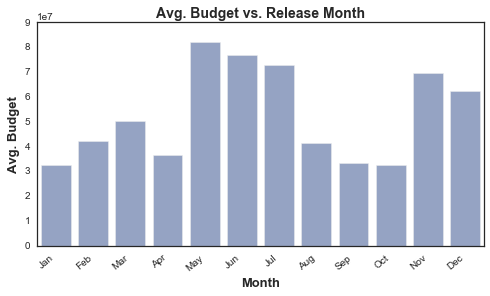

In [48]:
#Average budget vs. Release Month
months = complete.groupby('Release_Month')['adjusted_budget'].mean().sort_index()
ax = sns.barplot(months.index, months.values, color="#8da0cb")
plt.xlabel('Month', fontsize=13, weight='bold')
plt.ylabel('Avg. Budget', fontsize=13, weight='bold')
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names, rotation=40, ha='right')
plt.title('Avg. Budget vs. Release Month', fontsize=14, weight='bold')
plt.show()

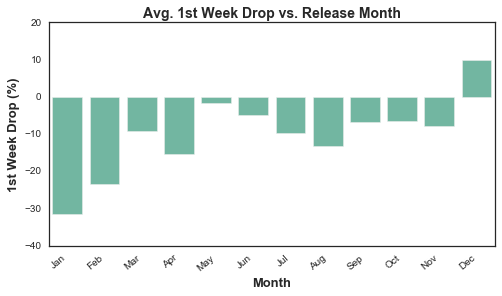

In [49]:
#Average 1st week drop vs. release month
months = complete.groupby('Release_Month')['w2_$_change'].mean().sort_index()
ax = sns.barplot(months.index, months.values, color="#66c2a5")
plt.xlabel('Month', fontsize=13, weight='bold')
plt.ylabel('1st Week Drop (%)', fontsize=13, weight='bold')
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names, rotation=40, ha='right')
plt.title('Avg. 1st Week Drop vs. Release Month', fontsize=14, weight='bold')
plt.show()

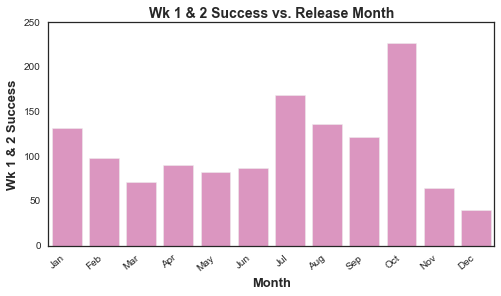

In [50]:
#Average 1st & 2nd week success vs. release month
months = complete.groupby('Release_Month')['w_1_and_2_success'].mean().sort_index()
ax = sns.barplot(months.index, months.values, color="#e78ac3")
plt.xlabel('Month', fontsize=13, weight='bold')
plt.ylabel('Wk 1 & 2 Success', fontsize=13, weight='bold')
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names, rotation=40, ha='right')
plt.title('Wk 1 & 2 Success vs. Release Month', fontsize=14, weight='bold')
plt.show()

##### Q7. How successful could Batman vs. Superman have been?

In [51]:
bvs = complete[complete.movieID == "id=superman2015.htm"]
bvs

,movieLink,movieID,name,AdjustedDomesticGross,ReleaseDate,Distributor,Genre,Budget,_merge,Release_Year,...,w_3_gross,w_3_rank,Major_Genre,w1_$_drop,budget_val,adjusted_budget,abs_profit,rel_profit,w_1_success,w_1_and_2_success
13880,/movies/?id=superman2015.htm,id=superman2015.htm,Batman v Superman: Dawn of Justice,319768300.0,2016-03-25,Warner Bros.,Action / Adventure,$250 million,both,2016.0,...,22954600.0,2.0,Action/Adventure,112667300.0,250000000.0,247500000.0,72268300.0,1.291993,0.659011,86.27996


In [52]:
#We will also look at Captain America Civil War as a Comparison
cw = complete[complete.movieID == "id=marvel2016.htm"]
cw

,movieLink,movieID,name,AdjustedDomesticGross,ReleaseDate,Distributor,Genre,Budget,_merge,Release_Year,...,w_3_gross,w_3_rank,Major_Genre,w1_$_drop,budget_val,adjusted_budget,abs_profit,rel_profit,w_1_success,w_1_and_2_success
13842,/movies/?page=weekend&id=marvel2016.htm,id=marvel2016.htm,Captain America: Civil War,290792000.0,2016-05-06,Buena Vista,Action / Adventure,$250 million,both,2016.0,...,NaN,NaN,Action/Adventure,104640000.0,250000000.0,247500000.0,43292000.0,1.174917,0.711141,99.949333


In [53]:
#We will also look at Dark Knight Rises as a Comparison
dk = complete[complete.movieID == "id=batman3.htm"]
dk

,movieLink,movieID,name,AdjustedDomesticGross,ReleaseDate,Distributor,Genre,Budget,_merge,Release_Year,...,w_3_gross,w_3_rank,Major_Genre,w1_$_drop,budget_val,adjusted_budget,abs_profit,rel_profit,w_1_success,w_1_and_2_success
14007,/movies/?id=batman3.htm,id=batman3.htm,The Dark Knight Rises,485414600.0,2012-07-20,Warner Bros.,Action Thriller,$250 million,both,2012.0,...,38723100.0,1.0,Action/Adventure,107039100.0,250000000.0,257500000.0,227914600.0,1.885105,0.677006,93.832583


In [54]:
print("Total Budget: {}".format(bvs.iloc[0]['Budget']))
print("Total Budget: ${:,.0f}".format(bvs.iloc[0]['budget_val']))
print("Opening Weekend: ${:,.0f}".format(bvs.iloc[0]['w_1_gross']))
print("2nd Weekend: ${:,.0f}".format(bvs.iloc[0]['w_2_gross']))
print("$ drop between 1st and 2nd weekend: -${:,.0f}".format(bvs.iloc[0]['w1_$_drop']))
print("pc change between 1st and 2nd weekend: {}%".format(bvs.iloc[0]['w2_$_change']))
print("Genre: {}".format(bvs.iloc[0]['Major_Genre']))

Total Budget: $250 million
Total Budget: $250,000,000
Opening Weekend: $163,105,100
2nd Weekend: $50,437,800
$ drop between 1st and 2nd weekend: -$112,667,300
pc change between 1st and 2nd weekend: -69.1%
Genre: Action/Adventure


###### First need to find a good comparison group

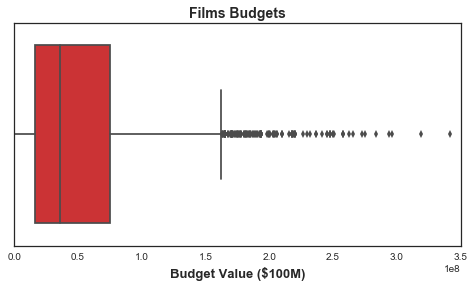

In [55]:
# What are big budgets?
ax = sns.boxplot(complete['adjusted_budget'], color="#e41a1c")
plt.xlabel('Budget Value ($100M)', fontsize=13, weight='bold')
plt.title('Films Budgets', fontsize=14, weight='bold')
plt.show()

In [56]:
# What genres are big budget movies?
complete[complete['adjusted_budget'] >= 130000000].groupby('Major_Genre').size().sort_values(ascending=False)

Major_Genre
Action/Adventure    95
Other               63
Animation           51
SciFi               50
Drama/Thriller       7
Horror               3
Comedy               2
Romance              1
dtype: int64

#Consider Major Genre = Action/Adventure and SciFi

In [57]:
comparison = complete[(complete['adjusted_budget'] >= 100000000) & (complete['Release_Year'] >= 2010)
                     & ((complete['Major_Genre'] == 'Action/Adventure') | (complete['Major_Genre'] == 'SciFi'))]

In [58]:
len(comparison)

89

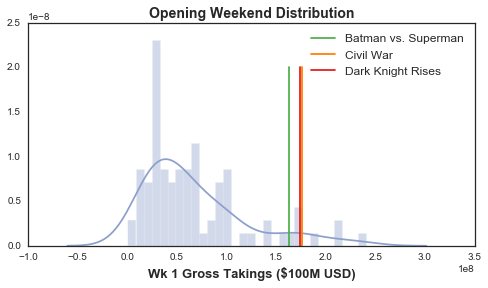

In [59]:
# How did Batman vs. Superman perform on opening weekend?
ax = sns.distplot(comparison['w_1_gross'].dropna(), color="#8da0cb",bins=30)
plt.xlabel('Wk 1 Gross Takings ($100M USD)', fontsize=13, weight='bold')
plt.title('Opening Weekend Distribution', fontsize=14, weight='bold')
plt.axvline(bvs.iloc[0]['w_1_gross'], color='#4daf4a', ymax=0.8, label="Batman vs. Superman")
plt.axvline(cw.iloc[0]['w_1_gross'], color='#ff7f00', ymax=0.8, label="Civil War")
plt.axvline(dk.iloc[0]['w_1_gross'], color='#e41a1c', ymax=0.8, label="Dark Knight Rises")
plt.legend(fontsize=12)
plt.show()

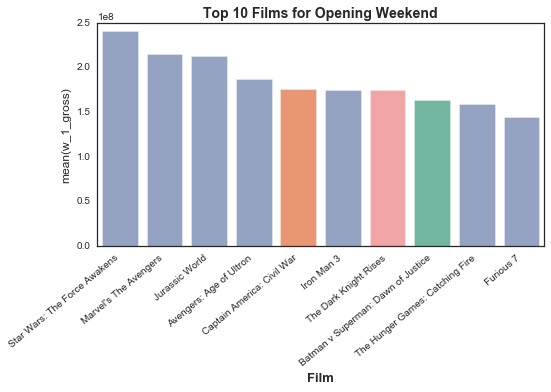

In [60]:
# Which are the top 10 films in this comparison group for opening weekend?
top10 = comparison.sort_values(by='w_1_gross', ascending=False).head(10)[['name','w_1_gross']]
colors = ["#8da0cb","#8da0cb","#8da0cb","#8da0cb","#fc8d62","#8da0cb","#fb9a99","#66c2a5","#8da0cb","#8da0cb"]
ax = sns.barplot(top10['name'], top10['w_1_gross'], palette=colors)
plt.xlabel('Film', fontsize=13, weight='bold')
ax.set_xticklabels(top10['name'], rotation=40, ha='right')
plt.title('Top 10 Films for Opening Weekend', fontsize=14, weight='bold')
plt.show()

In [61]:
sns.set_context(rc={"figure.figsize": (10,6)})

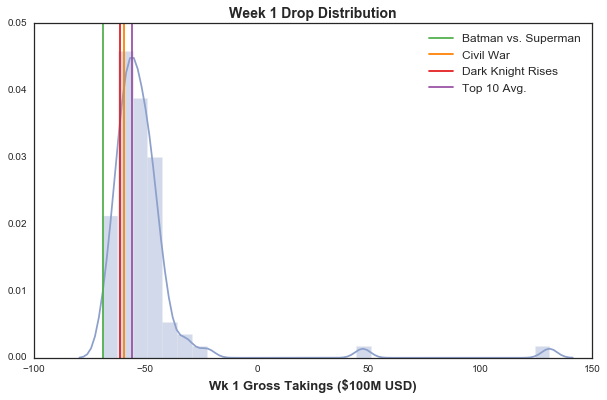

In [62]:
# Look at % drop between weekend 1 and weekend 2
ax = sns.distplot(comparison['w2_$_change'].dropna(), color="#8da0cb",bins=30)
plt.xlabel('Wk 1 Gross Takings ($100M USD)', fontsize=13, weight='bold')
plt.title('Week 1 Drop Distribution', fontsize=14, weight='bold')
plt.axvline(bvs.iloc[0]['w2_$_change'], color='#4daf4a', ymax=1, label="Batman vs. Superman")
plt.axvline(cw.iloc[0]['w2_$_change'], color='#ff7f00', ymax=1, label="Civil War")
plt.axvline(dk.iloc[0]['w2_$_change'], color='#e41a1c', ymax=1, label="Dark Knight Rises")
plt.axvline(comparison.sort_values(by='w_1_gross', ascending=False).head(10)['w2_$_change'].mean(), color='#984ea3',
           ymax=1, label="Top 10 Avg.")
plt.legend(fontsize=12)
plt.show()

In [63]:
#Look at a sub comparison group which is the top 10 for opening weekend takings
comp_sub = comparison[['name','w_1_and_2_success']].reset_index(drop=True)

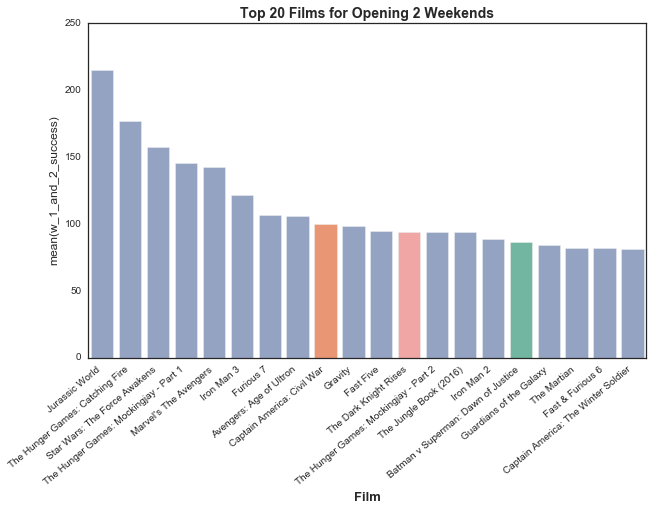

In [64]:
# Which are the top 20 films in this comparison group for opening 2 weekends?
top20 = comp_sub.sort_values(by='w_1_and_2_success', ascending=False).head(20)
colors = ["#8da0cb","#8da0cb","#8da0cb","#8da0cb","#8da0cb","#8da0cb","#8da0cb","#8da0cb","#fc8d62","#8da0cb",
          "#8da0cb","#fb9a99","#8da0cb","#8da0cb","#8da0cb","#66c2a5","#8da0cb","#8da0cb","#8da0cb","#8da0cb"]
ax = sns.barplot(top20['name'], top20['w_1_and_2_success'],palette=colors)
plt.xlabel('Film', fontsize=13, weight='bold')
ax.set_xticklabels(top20['name'], rotation=40, ha='right')
plt.title('Top 20 Films for Opening 2 Weekends', fontsize=14, weight='bold')
plt.show()

In [65]:
# What would Batman vs. Superman have looked like if the drop was same as average of the top 10
# Or if the drop was the same as Civil War
# Or if the drop was the same as Dark Knight Rises

scenarios = ['Actual','Top Avg Performance','Civil War','Dark Knight Rises']
week2 = []
week2.append(bvs.iloc[0]['w_2_gross'])

# Using average drop
new_w2 = bvs.iloc[0]['w_1_gross'] * (1 + comparison.sort_values(by='w_1_gross', ascending=False).head(10)['w2_$_change'].mean()/100)
week2.append(new_w2)

# Using civil war
new_w2_cw = bvs.iloc[0]['w_1_gross'] * (1 + cw['w2_$_change'].mean()/100)
week2.append(new_w2_cw)

# Using Dark Knight Rises
new_w2_dk = bvs.iloc[0]['w_1_gross'] * (1 + dk['w2_$_change'].mean()/100)
week2.append(new_w2_dk)

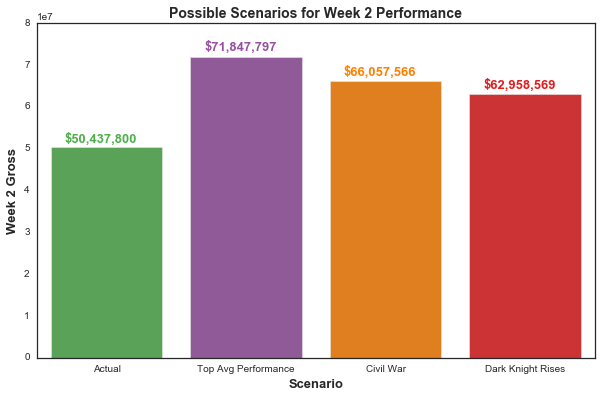

In [66]:
colors=['#4daf4a','#984ea3','#ff7f00','#e41a1c']
ax = sns.barplot(scenarios,week2,palette=colors)
plt.xlabel('Scenario', fontsize=13, weight='bold')
plt.ylabel('Week 2 Gross', fontsize=13, weight='bold')
plt.title('Possible Scenarios for Week 2 Performance', fontsize=14, weight='bold')
for p,v,c in zip(ax.patches,week2,colors):
    height = p.get_height()*1.02
    ax.text(p.get_x()+0.1, height, '${:,.0f}'.format(v), fontsize=13, weight='bold',color=c)
plt.show()

##### Q8. Bonus question: is there a relationship between budget and success?

In [67]:
#Only consider films greater than a year old
older_films = complete[((complete['Release_Year'] == 2015.0) & (complete['Release_Month'] <= 6.0))
                      | (complete['Release_Year'] <= 2014.0)]
older_films = older_films[older_films['adjusted_budget'].notnull() & older_films['w_1_gross'].notnull()]
older_films = older_films[older_films['adjusted_budget'] >= 1000000]

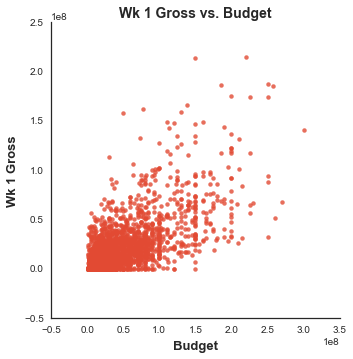

In [68]:
ax = sns.lmplot("budget_val","w_1_gross",data=older_films, fit_reg=False)
plt.xlabel('Budget', fontsize=13, weight='bold')
plt.ylabel('Wk 1 Gross', fontsize=13, weight='bold')
plt.title('Wk 1 Gross vs. Budget', fontsize=14, weight='bold')
plt.show()

In [69]:
sub_older = older_films[(older_films['adjusted_budget'] <= 100000000) & (older_films['w_1_gross'] <= 50000000)]

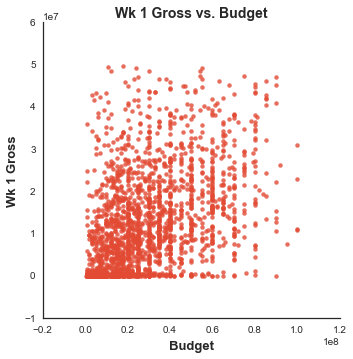

In [70]:
ax = sns.lmplot("budget_val","w_1_gross",data=sub_older, fit_reg=False)
plt.xlabel('Budget', fontsize=13, weight='bold')
plt.ylabel('Wk 1 Gross', fontsize=13, weight='bold')
plt.title('Wk 1 Gross vs. Budget', fontsize=14, weight='bold')
plt.show()

In [71]:
sub_sub = older_films[(older_films['adjusted_budget'] <= 50000000) & (older_films['w_1_gross'] <= 25000000)]

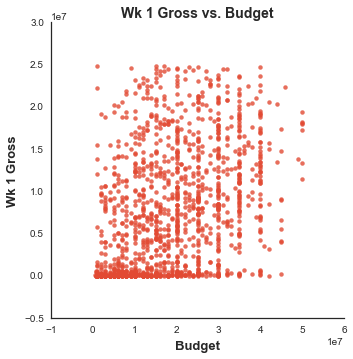

In [72]:
ax = sns.lmplot("budget_val","w_1_gross",data=sub_sub, fit_reg=False)
plt.xlabel('Budget', fontsize=13, weight='bold')
plt.ylabel('Wk 1 Gross', fontsize=13, weight='bold')
plt.title('Wk 1 Gross vs. Budget', fontsize=14, weight='bold')
plt.show()